In [1]:
#Versão da linguagem Python
from platform import python_version
print("versão da linguagem python usada neste Jupyter Notbook", python_version())

versão da linguagem python usada neste Jupyter Notbook 3.11.9


# Preparativos

In [2]:
#Importar a findspark
import findspark

In [3]:
#Inicializar findspark
findspark.init()
'''
O findspark ajuda a localizar o diretório do Spark e adicioná-lo ao caminho do sistema, permitindo que seja usado o PySpark sem precisar configurar manualmente as variáveis de ambiente.
Ela é especialmente útil quando o PySpark não está instalado no mesmo diretório que o Python ou quando está sendo usando em um ambiente virtual.
'''

'\nO findspark ajuda a localizar o diretório do Spark e adicioná-lo ao caminho do sistema, permitindo que seja usado o PySpark sem precisar configurar manualmente as variáveis de ambiente.\nEla é especialmente útil quando o PySpark não está instalado no mesmo diretório que o Python ou quando está sendo usando em um ambiente virtual.\n'

In [4]:
#Importar SparkSession
from pyspark.sql import SparkSession as Ss

In [5]:
# Construir Session
spark = Ss.builder\
    .master("local")\
    .appName("CarrosClustering")\
    .getOrCreate()
'''
A SparkSession gerencia o SparkContext internamente não sendo necessário criar um SparkContext separadamente.
master("local") - para facilitar depuração e a análise de resultados (O Spark será executado em um único nó).
'''

'\nA SparkSession gerencia o SparkContext internamente não sendo necessário criar um SparkContext separadamente.\nmaster("local") - para facilitar depuração e a análise de resultados (O Spark será executado em um único nó).\n'

In [6]:
# Definir o nível de log durante a execução:
spark.sparkContext.setLogLevel("ERROR")
'''
A melhor prática é definir o nível de log usando a configuração spark.log.level no arquivo spark-defaults.conf
ou através do comando spark-submit. Isso garante que o nível de log seja aplicado a todo o aplicativo Spark.
No entanto, para fins de depuração e desenvolvimento, é aceitável definir o nível de log diretamente no código.
Isso pode ser útil para evitar mensagens de log excessivas durante o desenvolvimento e depuração.
No entanto, é importante lembrar de reverter essa configuração para um nível de log mais apropriado (como WARN ou INFO) em ambientes de produção.
'''

'\nA melhor prática é definir o nível de log usando a configuração spark.log.level no arquivo spark-defaults.conf\nou através do comando spark-submit. Isso garante que o nível de log seja aplicado a todo o aplicativo Spark.\nNo entanto, para fins de depuração e desenvolvimento, é aceitável definir o nível de log diretamente no código.\nIsso pode ser útil para evitar mensagens de log excessivas durante o desenvolvimento e depuração.\nNo entanto, é importante lembrar de reverter essa configuração para um nível de log mais apropriado (como WARN ou INFO) em ambientes de produção.\n'

# Carregar os dados

In [7]:
# Criar DataFrame a partir de um arquivo CSV
carrosDF = spark.read.csv("dados/dataset.csv", header=True, inferSchema=True, sep=";")
'''
O PySpark lê o arquivo CSV e cria um DataFrame, que é uma estrutura de dados distribuída semelhante a uma tabela em um banco de dados relacional.
O DataFrame é otimizado para processamento distribuído e pode ser manipulado usando operações semelhantes ao SQL.
header = True - indica que a primeira linha do arquivo CSV contém os nomes das colunas
inferSchema - será inferido os tipos de dados em cada coluna
sep=";" - separador do arquivo CSV
'''

'\nO PySpark lê o arquivo CSV e cria um DataFrame, que é uma estrutura de dados distribuída semelhante a uma tabela em um banco de dados relacional.\nO DataFrame é otimizado para processamento distribuído e pode ser manipulado usando operações semelhantes ao SQL.\nheader = True - indica que a primeira linha do arquivo CSV contém os nomes das colunas\ninferSchema - será inferido os tipos de dados em cada coluna\nsep=";" - separador do arquivo CSV\n'

In [8]:
#Visualizar a Estrutura do DataFrame
carrosDF.printSchema()
'''
O método printSchema() exibe a estrutura do DataFrame, incluindo os nomes das colunas e os tipos de dados inferidos.
Isso é útil para verificar se os dados foram lidos corretamente e se os tipos de dados estão corretos.
'''

root
 |-- fabricante: string (nullable = true)
 |-- tipo_combustivel: string (nullable = true)
 |-- aspirado: string (nullable = true)
 |-- portas: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- direcao: string (nullable = true)
 |-- cilindros: string (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- rpm: integer (nullable = true)
 |-- consumo_cidade: integer (nullable = true)
 |-- consumo_estrada: integer (nullable = true)
 |-- preco: integer (nullable = true)



'\nO método printSchema() exibe a estrutura do DataFrame, incluindo os nomes das colunas e os tipos de dados inferidos.\nIsso é útil para verificar se os dados foram lidos corretamente e se os tipos de dados estão corretos.\n'

In [9]:
#Visualizar tabela
carrosDF.show(5)

+----------+----------------+--------+------+---------+-------+---------+----------+----+--------------+---------------+-----+
|fabricante|tipo_combustivel|aspirado|portas|     tipo|direcao|cilindros|horsepower| rpm|consumo_cidade|consumo_estrada|preco|
+----------+----------------+--------+------+---------+-------+---------+----------+----+--------------+---------------+-----+
|    subaru|             gas|     std|   two|hatchback|    fwd|     four|        69|4900|            31|             36| 5118|
| chevrolet|             gas|     std|   two|hatchback|    fwd|    three|        48|5100|            47|             53| 5151|
|     mazda|             gas|     std|   two|hatchback|    fwd|     four|        68|5000|            30|             31| 5195|
|    toyota|             gas|     std|   two|hatchback|    fwd|     four|        62|4800|            35|             39| 5348|
|mitsubishi|             gas|     std|   two|hatchback|    fwd|     four|        68|5500|            37|       

# Pré-processamento dos dados

In [ ]:
#Iremos usar para o modelo
##Portas            - Categórico
##Tipo              - Categórico
##Horsepower        - Numérico
##Rpm               - Numérico
##Concumo_cidade    - Numérico

In [12]:
#Criando novo DF com apenas as colunas desejadas
novoCarrosDF = carrosDF.select("portas","tipo","horsepower","rpm","consumo_cidade")
novoCarrosDF.show(5)

+------+---------+----------+----+--------------+
|portas|     tipo|horsepower| rpm|consumo_cidade|
+------+---------+----------+----+--------------+
|   two|hatchback|        69|4900|            31|
|   two|hatchback|        48|5100|            47|
|   two|hatchback|        68|5000|            30|
|   two|hatchback|        62|4800|            35|
|   two|hatchback|        68|5500|            37|
+------+---------+----------+----+--------------+
only showing top 5 rows



In [13]:
# Eliminar valores duplicados se houver
#O método distinct() retorna um novo DataFrame que contém apenas as linhas distintas do DataFrame original.
linnhasInicias = novoCarrosDF.count()
print("Número de linhas antes de eliminar duplicados:", linnhasInicias)
novoCarrosDF = novoCarrosDF.distinct()
linhasFinais = novoCarrosDF.count()
print("Número de linhas após eliminar duplicados:", linhasFinais)
print("Número de linhas eliminadas:", linnhasInicias - linhasFinais)

Número de linhas antes de eliminar duplicados: 197
Número de linhas após eliminar duplicados: 147
Número de linhas eliminadas: 50


In [14]:
#Transformando as colunas numéricas em float
colunas2=["horsepower", "rpm","consumo_cidade"]
CarrosDF2 = novoCarrosDF
for col in colunas2:
    CarrosDF2 = CarrosDF2.withColumn(col+"f",CarrosDF2[col].cast("float")).drop(col)

CarrosDF2.show()

+------+-----------+-----------+------+---------------+
|portas|       tipo|horsepowerf|  rpmf|consumo_cidadef|
+------+-----------+-----------+------+---------------+
|   two|    hardtop|      207.0|5900.0|           17.0|
|  four|      wagon|       94.0|5200.0|           25.0|
|  four|      sedan|       69.0|5200.0|           31.0|
|  four|      sedan|       56.0|4500.0|           34.0|
|  four|      wagon|      123.0|4350.0|           22.0|
|  four|      sedan|      162.0|5100.0|           17.0|
|  four|  hatchback|       84.0|4800.0|           26.0|
|   two|  hatchback|       69.0|4900.0|           31.0|
|   two|  hatchback|       68.0|5500.0|           37.0|
|  four|      sedan|      152.0|5200.0|           17.0|
|   two|  hatchback|       90.0|5500.0|           24.0|
|   two|convertible|       90.0|5500.0|           24.0|
|  four|      sedan|       70.0|5400.0|           38.0|
|  four|      sedan|      121.0|4250.0|           20.0|
|  four|      sedan|      116.0|5500.0|         

In [ ]:
#Importar funções para analise dos dados
#from pyspark.sql.functions import count, col, asc, desc, when

In [15]:
#Identificar Valores únicos em portas
portasDf = CarrosDF2.groupBy("portas").count()
portasDf.show()

+------+-----+
|portas|count|
+------+-----+
|   two|   59|
|  four|   88|
+------+-----+



In [16]:
#Identificar Valores únicos em tipo
tipoDf = CarrosDF2.groupBy("tipo").count()
tipoDf.show()

+-----------+-----+
|       tipo|count|
+-----------+-----+
|      wagon|   20|
|convertible|    5|
|      sedan|   72|
|  hatchback|   45|
|    hardtop|    5|
+-----------+-----+



------

### Representar Variáveis caregóricas

PROCESSO 1

Etapas:
- Identificar categorias únicas presentes no DataFrame;
- Atribuir um índice acada categoria identificada;
- Criar uma coluna com os índices


Uso: *StringIndexer*

In [17]:
#Importar classe para converter colunas de strings em índices numéricos
from pyspark.ml.feature import StringIndexer

Personalizações:
- O parêmetro StringOrderType permite alterar a ordem de atribuição de índices.
- O parêmetro HandleInvalid permite definir como valores desconhecidos e inválidos serão tratados.

In [18]:
#Criar a indexação das colunas categóricas (sem personalização)
indexer_portas = StringIndexer(inputCol="portas", outputCol="portas_indexadas")
indexer_tipo = StringIndexer(inputCol="tipo", outputCol="tipo_indexado")
'''A classe StringIndexer converte colunas categóricas em índices numéricos, atribuindo um número inteiro a cada categoria.
O índice atribuído é baseado na frequência da categoria, onde a categoria mais frequente recebe o índice 0, a segunda mais frequente recebe o índice 1 e assim por diante.'''



'A classe StringIndexer converte colunas categóricas em índices numéricos, atribuindo um número inteiro a cada categoria.\nO índice atribuído é baseado na frequência da categoria, onde a categoria mais frequente recebe o índice 0, a segunda mais frequente recebe o índice 1 e assim por diante.'

PROCESSO 2 - 

Etapas:
- Criar um vetor binário para cada índice númérico obtido pelo StringIndexer;
- Atribuir o valor 1 a posição correpondente ao índice e 0 nas demais posições.

Uso: *OneHotEncoder*

In [19]:
#Importar classe para transformar os índices numéricos em vetores binários (one-hot encoded vectors)
from pyspark.ml.feature import OneHotEncoder

In [20]:
# One-Hot Encoding
encoder = OneHotEncoder(inputCols=["portas_indexadas", "tipo_indexado"], outputCols=["portas_encoded", "tipo_encoded"])

PROCESSO 3 - Vetorização

Etapas:
- Concatena os valores dessas colunas em uma única estrutura de dados

Uso: VectorAssembler


In [21]:
#Importar classe para combinar várias colunas em uma coluna de vetor
from pyspark.ml.feature import VectorAssembler

In [ ]:
#Realizar a Vetorização das features
assembler = VectorAssembler(inputCols=["portas_encoded", "tipo_encoded", "horsepowerf", "rpmf", "consumo_cidadef"], outputCol="features_nao_escaladas")
'''
O VectorAssembler combina várias colunas em uma única coluna de vetor, o que é necessário para a maioria dos algoritmos de aprendizado de máquina no Spark.
O parâmetro inputCols especifica as colunas de entrada que serão combinadas, e o parâmetro outputCol especifica o nome da coluna de saída que conterá o vetor resultante.
O parâmetro handleInvalid="skip" é usado para lidar com valores inválidos durante a transformação. Nesse caso, os valores inválidos serão ignorados e não incluídos no vetor resultante.
O parâmetro outputCol especifica o nome da coluna de saída que conterá o vetor resultante.

'''

'\nO VectorAssembler combina várias colunas em uma única coluna de vetor, o que é necessário para a maioria dos algoritmos de aprendizado de máquina no Spark.\nO parâmetro inputCols especifica as colunas de entrada que serão combinadas, e o parâmetro outputCol especifica o nome da coluna de saída que conterá o vetor resultante.\nO parâmetro handleInvalid="skip" é usado para lidar com valores inválidos durante a transformação. Nesse caso, os valores inválidos serão ignorados e não incluídos no vetor resultante.\nO parâmetro outputCol especifica o nome da coluna de saída que conterá o vetor resultante.\n\n'

PROCESSO 4 - Normalização dos dados

Etapas:
- Centralizar os dados [Média=0];
- escala os dados [Desvio Padrão=1];
Requisito: Mantem a distribuição original dos daods

Uso: StandardScaler

A média e o desvio padrão utilizados para o escalonamento devem ser calculados apenas no conjunto de treinamento.

O StandardScaler funciona melhor quando as features têm distribuições aproximadamente normais.

Quando considerar outros métodos?
Outliers: Se os seus dados tiverem muitos outliers, o RobustScaler pode ser uma opção melhor, pois ele é menos sensível a outliers.
Dados com valores limitados: Se os seus dados estão limitados a um determinado intervalo (por exemplo, entre 0 e 1), o MinMaxScaler pode ser mais adequado.

In [23]:
#Importar classe para padronizar as features do conjunto de dados
from pyspark.ml.feature import StandardScaler

In [24]:
# Padronizar as features
scaler = StandardScaler(inputCol="features_nao_escaladas", outputCol="features", withStd=True, withMean=True)
'''
O StandardScaler é usado para padronizar as features, ou seja, ajustar a média e o desvio padrão de cada feature para que tenham média 0 e desvio padrão 1.
O parâmetro withStd=True indica que o escalonamento deve ser feito com base no desvio padrão, enquanto withMean=True indica que a média deve ser subtraída.
Isso é útil para garantir que todas as features tenham a mesma escala e contribuam igualmente para o modelo de aprendizado de máquina.
'''

'\nO StandardScaler é usado para padronizar as features, ou seja, ajustar a média e o desvio padrão de cada feature para que tenham média 0 e desvio padrão 1.\nO parâmetro withStd=True indica que o escalonamento deve ser feito com base no desvio padrão, enquanto withMean=True indica que a média deve ser subtraída.\nIsso é útil para garantir que todas as features tenham a mesma escala e contribuam igualmente para o modelo de aprendizado de máquina.\n'

PROCESSO 5

Etapas:
- Definir a sequêcncia de etapas de preparo e treinamento;
- Executar as stages em ordem;
- Aplicar os stage a aos dados de treinamento.
- Realizar previão em novos dados

Uso: *Pipeline*

Personalizações:
- Hyperparameter tuning: O Pipeline pode ser usado em conjunto com ferramentas de otimização de hiperparâmetros, como o GridSearchCV, para encontrar os melhores valores para os parâmetros dos modelos.

In [25]:
#Importar classe para gerenciar fluxo de trabalho estruturada e sequencial
from pyspark.ml import Pipeline

In [26]:
# Criar Pipeline
pipeline = Pipeline(stages=[indexer_portas, indexer_tipo, encoder, assembler, scaler])
'''O pipeline é uma sequência de transformações que serão aplicadas aos dados.'''


'O pipeline é uma sequência de transformações que serão aplicadas aos dados.'

In [27]:
# Aplicar o pipeline aos dados
carrosDfPreparado = pipeline.fit(CarrosDF2).transform(CarrosDF2)

In [ ]:
# Visualizar os dados preparados
carrosDfPreparado.show(5)

+------+---------+-----------+------+---------------+----------------+-------------+--------------+-------------+----------------------+--------------------+
|portas|     tipo|horsepowerf|  rpmf|consumo_cidadef|portas_indexadas|tipo_indexado|portas_encoded| tipo_encoded|features_nao_escaladas|            features|
+------+---------+-----------+------+---------------+----------------+-------------+--------------+-------------+----------------------+--------------------+
|   two|hatchback|       69.0|4900.0|           31.0|             1.0|          1.0|     (1,[],[])|(4,[1],[1.0])|  (8,[2,5,6,7],[1.0...|[-1.1449709581789...|
|   two|hatchback|       48.0|5100.0|           47.0|             1.0|          1.0|     (1,[],[])|(4,[1],[1.0])|  (8,[2,5,6,7],[1.0...|[-1.1449709581789...|
|   two|hatchback|       68.0|5000.0|           30.0|             1.0|          1.0|     (1,[],[])|(4,[1],[1.0])|  (8,[2,5,6,7],[1.0...|[-1.1449709581789...|
|   two|hatchback|       62.0|4800.0|           35.0

In [ ]:
# Visualizar os dados de features não escaladas
carrosDfPreparado.select("features_nao_escaladas").show(3, False)

+------------------------------------+
|features_nao_escaladas              |
+------------------------------------+
|(8,[2,5,6,7],[1.0,69.0,4900.0,31.0])|
|(8,[2,5,6,7],[1.0,48.0,5100.0,47.0])|
|(8,[2,5,6,7],[1.0,68.0,5000.0,30.0])|
+------------------------------------+
only showing top 3 rows



In [ ]:
# Visualizar os dados de features já escalados sem truncar os valores longos
carrosDfPreparado.select("features").show(3, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.2171191364344232,-0.976457570893432,-0.6619480871700161,-0.3954858029070498,-0.18700731315363694,2.5794636704236793,1.6467788186897516,-1.189667699989668]   |
|[0.8160230573821701,-0.976457570893432,-0.6619480871700161,2.5113348484597657,-0.18700731315363694,-0.29004282766148975,0.1941123768279837,-0.011024721735371928]|
|[0.8160230573821701,1.0171433030139918,-0.6619480871700161,-0.3954858029070498,-0.18700731315363694,-0.9248893980343148,0.1941123768279837,0.8729575119553502]   |
+---------------

In [29]:
#Importando a classe ClusteringEvaluator para avaliar a qualidade dos clusters
from pyspark.ml.evaluation import ClusteringEvaluator

In [30]:
#Avaliar Clustering
avaliador = ClusteringEvaluator()

In [31]:
#Importando classe KMeans para clusterização K-means
from pyspark.ml.clustering import KMeans

In [32]:
#Testar numeros diferentes de clusters
#Será usado o método Silhueta que mede a coesão e a separação dos clusters
#Objetivo: Encontrar k que Máximize a pontuação da silhueta
resultados = {}
for k in range(2,6):
    kmeans = KMeans(k=k,seed=1)
    model = kmeans.fit(carrosDfPreparado.select("features"))
    predictions = model.transform(carrosDfPreparado.select("features"))
    silhouette = avaliador.evaluate(predictions)
    resultados[k]=silhouette

In [33]:
#Resultado
print(f"Para k={max(resultados,key=resultados.get)}, silhueta é {resultados[max(resultados,key=resultados.get)]}")

Para k=5, silhueta é 0.5266775941180634


In [59]:
# Criando modelo
kmeans = KMeans(k=5, seed=1)

In [60]:
#Treinando o modelo
modelo = kmeans.fit(carrosDfPreparado.select("features"))
'''O modelo é treinado usando o método fit, que ajusta o modelo aos dados de entrada. O resultado é um modelo KMeans treinado que pode ser usado para prever os clusters dos dados.
O modelo KMeans é um algoritmo de aprendizado não supervisionado que agrupa os dados em k clusters com base nas características fornecidas.
O parâmetro k especifica o número de clusters a serem formados, e o parâmetro seed é usado para garantir a reprodutibilidade dos resultados.
'''


'O modelo é treinado usando o método fit, que ajusta o modelo aos dados de entrada. O resultado é um modelo KMeans treinado que pode ser usado para prever os clusters dos dados.\nO modelo KMeans é um algoritmo de aprendizado não supervisionado que agrupa os dados em k clusters com base nas características fornecidas.\nO parâmetro k especifica o número de clusters a serem formados, e o parâmetro seed é usado para garantir a reprodutibilidade dos resultados.\n'

In [61]:
#Predição
previsoes = modelo.transform(carrosDfPreparado.select("features"))
#Visualizar previsões
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.2171191364344...|         3|
|[0.81602305738217...|         2|
|[0.81602305738217...|         4|
|[0.81602305738217...|         4|
|[0.81602305738217...|         2|
|[0.81602305738217...|         3|
|[0.81602305738217...|         1|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         1|
|[0.81602305738217...|         3|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         0|
|[0.81602305738217...|         4|
|[0.81602305738217...|         4|
|[0.81602305738217...|         3|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         1|
|[-1.2171191364344...|         1|
+--------------------+----------+
only showing top 20 rows



### Preparando a visualização das previsões

In [37]:
#Importar a biblioteca pandas
import pandas as pd

In [62]:
#Extrair as 5 caracteristicas das previsões (portas...)
def unstripData(instr):
  return (instr["prediction"],
          instr["features"][-3],# horsepowerf
          instr["features"][-2],# rpmf
          instr["features"][-1],# consumo_cidadef
          )

In [63]:
#Criar estrutura de dados distribuida
#Aplicar a função nas previsões
carrosRDD = previsoes.rdd.map(unstripData)
predList = carrosRDD.collect()

In [64]:
#Converter em DataFrame
predPd = pd.DataFrame(predList)
predPd.head(10)

,0,1,2,3
0,3,2.579464,1.646779,-1.189668
1,2,-0.290043,0.194112,-0.011025
2,4,-0.924889,0.194112,0.872958
3,4,-1.255010,-1.258554,1.314949
4,2,0.446379,-1.569840,-0.453016
5,3,1.436740,-0.013411,-1.189668
6,1,-0.543981,-0.635983,0.136306
7,1,-0.924889,-0.428459,0.872958
8,1,-0.950283,0.816684,1.756940
9,3,1.182801,0.194112,-1.189668


In [65]:
predPd.value_counts()

0  1          2          3        
3   1.995405  -1.258554  -1.631659    2
1  -1.102646  -0.635983   0.872958    2
4  -0.924889   0.194112   0.872958    2
1  -0.924889   0.194112   0.872958    2
4  -0.518588   0.297874   0.283636    2
                                     ..
1   1.385952   0.816684  -0.895007    1
               0.194112  -0.895007    1
    1.233589  -0.220935  -0.895007    1
    1.005044  -0.220935  -0.895007    1
4   0.446379  -1.569840  -0.453016    1
Name: count, Length: 134, dtype: int64

In [66]:
predPd.shape

(147, 4)

In [67]:
# Remover Linhas duplicadas
predPd_Limpo = predPd.drop_duplicates()
predPd_Limpo.shape

(134, 4)

In [93]:
# Analisar se está sendo gerado clusters com baixa coesão
# Analisar a distribioção
distribuicaoClusters = predPd.value_counts(0).reset_index()
# Renomear as colunas do DataFrame
distribuicaoClusters.columns = ["Cluster", "Quantidade"]
# Ordenar o DataFrame pela quantidade de forma decrescente
distribuicaoClusters = distribuicaoClusters.sort_values(by="Quantidade", ascending=False).reset_index(drop=True)
print( distribuicaoClusters)


   Cluster  Quantidade
0        1          48
1        3          38
2        4          36
3        2          20
4        0           5


# Visualização (utilizando o Pandas)

In [45]:
#Importando o módulo matplotlib.pylab para criação de gráficos
import matplotlib.pylab as plt

In [109]:
import matplotlib.cm as cm

In [76]:
# Número de clusters
n_clusters = distribuicaoClusters.shape[0]
# Gerar colormap
cmap = cm.get_cmap("viridis", n_clusters)
# Mapear os clusters para cores
clusterCores = [cmap(i) for i in range(n_clusters)]

C:\Users\sopro\AppData\Local\Temp\ipykernel_7816\4024355273.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", n_clusters)


In [ ]:
# Mapear os clusters para cores
cores_barras = distribuicaoClusters["Cluster"].map(lambda x: clusterCores[x])

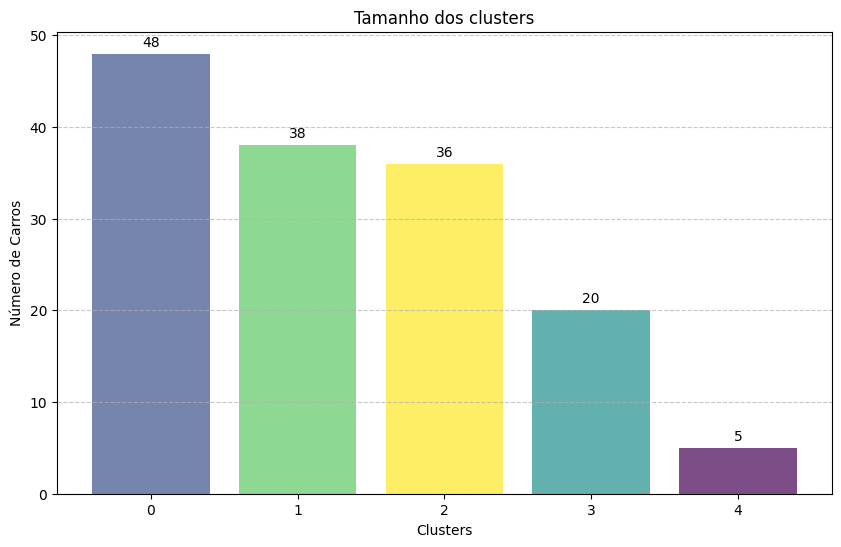

'#O gráfico mostra a distribuição dos carros em cada cluster, permitindo identificar se há clusters com baixa coesão ou se os dados estão bem distribuídos entre os clusters.\n'

In [108]:
plt.figure(figsize=(10, 6))
plt.title("Tamanho dos clusters")
plt.xlabel("Clusters")
plt.ylabel("Número de Carros")
# Criar gráfico de barras
plt.bar(distribuicaoClusters.index, distribuicaoClusters["Quantidade"], color=cores_barras, alpha=0.7,)
# Adicionar rótulos de valor acima de cada barra
for i, v in enumerate(distribuicaoClusters["Quantidade"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10, color="black")

plt.xticks(distribuicaoClusters["Cluster"], rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
'''#O gráfico mostra a distribuição dos carros em cada cluster, permitindo identificar se há clusters com baixa coesão ou se os dados estão bem distribuídos entre os clusters.
'''

In [ ]:
# Mapear os clusters para cores
cores_dispersao = predPd_Limpo["cluster"].map(lambda x: clusterCores[x])

<function matplotlib.pyplot.show(close=None, block=None)>

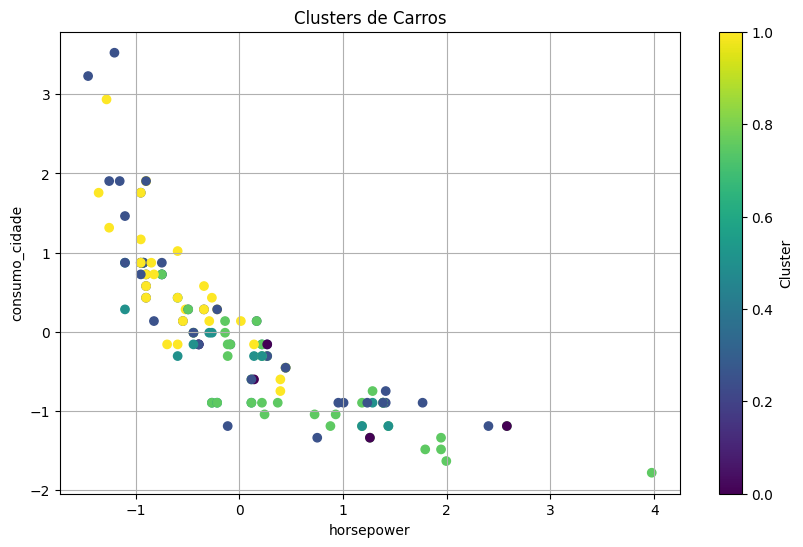

In [90]:
# Extrair nomes das colunas | Para desenhar o gráfico com rótulos mais claros
# Criar uma lista com os nomes das colunas
predPd_Limpo.columns = ["cluster", "horsepower", "rpm", "consumo_cidade"]
#Resultado das cluscters criadas
plt.figure(figsize=(10,6))
plt.scatter(predPd_Limpo["horsepower"],predPd_Limpo["consumo_cidade"],c=cores_dispersao)
plt.title("Clusters de Carros")
plt.xlabel("horsepower")
plt.ylabel("consumo_cidade")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

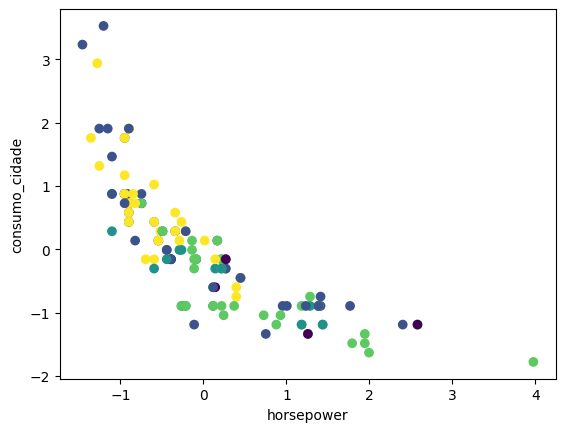

In [91]:
#Resultado das cluscters criadas
plt.cla()
plt.scatter(predPd_Limpo["horsepower"],predPd_Limpo["consumo_cidade"],c=cores_dispersao)
plt.xlabel("horsepower")
plt.ylabel("consumo_cidade")
plt.show

In [110]:
# Encerra a sessão Spark
spark.stop()

FIM